# Deep Learning: Example 1

The goal is to train a neural network to recognize hand-written digits using [the MNIST dataset](http://yann.lecun.com/exdb/mnist/). I am following [this tutorial](http://neuralnetworksanddeeplearning.com/chap1.html). I have modified the code slightly to be more Py3k friendly and also to improve readability a bit. I have also added some visual examples from the MNIST data.

To run this notebook on your own, you must download the [mnist.pkl.gz](http://deeplearning.net/data/mnist/mnist.pkl.gz) from the book's author and place it in the same directory as this notebook. (Do not `gunzip` it though: this script will decompress on the fly.)

In [83]:
import gzip
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random

%matplotlib inline
matplotlib.rc('font', family='Arial')

Some helper functions:

In [33]:
def load_data():
    def one_hot(n):
        e = np.zeros((10, 1))
        e[n] = 1.0
        return e

    with gzip.open('./mnist.pkl.gz') as mnist_file:
        train, validation, test = pickle.load(mnist_file, encoding='bytes')
    
    train_inputs = [np.reshape(x, (784, 1)) for x in train[0]]
    train_results = [one_hot(y) for y in train[1]]
    train_data = list(zip(train_inputs, train_results))
    
    validation_inputs = [np.reshape(x, (784, 1)) for x in validation[0]]
    validation_data = list(zip(validation_inputs, validation[1]))
    
    test_inputs = [np.reshape(x, (784, 1)) for x in test[0]]
    test_data = list(zip(test_inputs, test[1]))
    
    return train_data, validation_data, test_data

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    sz = sigmoid(z)
    return sz * (1 - sz)

And the definition of the Network class:

In [68]:
class Network:
    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y 
                        in zip(sizes[:-1], sizes[1:])]

    def backprop(self, x, y):
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]

        # Feed forward
        activation = x
        activations = [x]
        weighted_inputs = []
        
        for b, w in zip(self.biases, self.weights):
            weighted_input = np.dot(w, activation) + b
            weighted_inputs.append(weighted_input)
            activation = sigmoid(weighted_input)
            activations.append(activation)
        
        # Propagate backward
        delta = self.cost_derivative(activations[-1], y) * \
                sigmoid_prime(weighted_inputs[-1])
        grad_b[-1] = delta
        grad_w[-1] = np.dot(delta, activations[-2].transpose())
        
        for layer in range(2, self.num_layers):
            weighted_input = weighted_inputs[-layer]
            sp = sigmoid_prime(weighted_input)
            delta = np.dot(self.weights[-layer + 1].transpose(), delta) * sp
            grad_b[-layer] = delta
            grad_w[-layer] = np.dot(delta, activations[-layer  - 1].transpose())

        return grad_b, grad_w

    def cost_derivative(self, output_activations, y):
        return output_activations - y

    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)), y) 
                        for x, y in test_data]
        return sum(int(x == y) for x, y in test_results)

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a
    
    def update_mini_batch(self, mini_batch, learning_rate):
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]
        
        for x, y in mini_batch:
            delta_b, delta_w = self.backprop(x, y)
            grad_b = [gb + db for gb, db in zip(grad_b, delta_b)]
            grad_w = [gw + dw for gw, dw in zip(grad_w, delta_w)]
        
        self.biases = [b - (learning_rate/len(mini_batch)) * gb
                       for b, gb in zip(self.biases, grad_b)]
        self.weights = [w - (learning_rate/len(mini_batch)) * gw
                        for w, gw in zip(self.weights, grad_w)]

    def sgd(self, training_data, epochs, mini_batch_size, 
            learning_rate, test_data=None):
        if test_data is not None:
            n_test = len(test_data)
        n = len(training_data)
        for epoch in range(epochs):
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size] for k 
                            in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, learning_rate)
            if test_data:
                args = (
                    epoch,
                    self.evaluate(test_data),
                    n_test
                )
                print('Epoch {}: {} / {}'.format(*args))
            else:
                print('Epoch {} completed.'.format(epoch))

Load data and show some examples from training.

In [35]:
training_data, validation_data, test_data = load_data()

Show some examples from the test set with the actual label shown above each example.

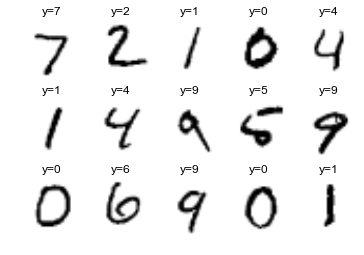

In [90]:
rows, cols = 3, 5
for i, (x, y) in enumerate(test_data[:rows*cols]):
    plt.subplot(rows, cols, i+1)
    plt.axis('off')
    plt.imshow(np.reshape(x, (28,28)), cmap='Greys')
    plt.title('y={}'.format(y))

Train a network. The performance of epoch (measured by test examples correctly labeled) is displayed as the networks trains. This step takes about 5-10 minutes on my laptop.

In [69]:
net = Network((784, 30, 10))
net.sgd(training_data, epochs=30, mini_batch_size=10, 
        learning_rate=3, test_data=test_data)

Epoch 0: 8990 / 10000
Epoch 1: 9229 / 10000
Epoch 2: 9314 / 10000
Epoch 3: 9367 / 10000
Epoch 4: 9395 / 10000
Epoch 5: 9380 / 10000
Epoch 6: 9401 / 10000
Epoch 7: 9431 / 10000
Epoch 8: 9431 / 10000
Epoch 9: 9435 / 10000
Epoch 10: 9452 / 10000
Epoch 11: 9436 / 10000
Epoch 12: 9483 / 10000
Epoch 13: 9454 / 10000
Epoch 14: 9464 / 10000
Epoch 15: 9508 / 10000
Epoch 16: 9514 / 10000
Epoch 17: 9483 / 10000
Epoch 18: 9500 / 10000
Epoch 19: 9499 / 10000
Epoch 20: 9501 / 10000
Epoch 21: 9486 / 10000
Epoch 22: 9493 / 10000
Epoch 23: 9469 / 10000
Epoch 24: 9484 / 10000
Epoch 25: 9516 / 10000
Epoch 26: 9515 / 10000
Epoch 27: 9521 / 10000
Epoch 28: 9492 / 10000
Epoch 29: 9498 / 10000


Show some randomly selected digits from the test set and use the neural network to predict the label. (Execute this cell again to pick a new set of random examples.)

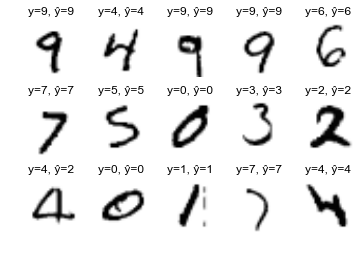

In [89]:
rows, cols = 3, 5

for i, (x, y) in enumerate(random.sample(test_data, rows * cols)):
    plt.subplot(rows, cols, i+1)
    plt.axis('off')
    plt.imshow(np.reshape(x, (28,28)), cmap='Greys')
    y_hat = np.argmax(net.feedforward(x))
    plt.title('y={}, ŷ={}'.format(y, y_hat))